In [33]:
import os
import sys

cwd = os.getcwd()
sys.path.append(os.path.join(cwd, '..'))

from sklearn.externals import joblib
from aye import *
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [34]:
# Reader
reader = DataReader(rel_dir='images', ext='jpg')

# Detector
clf = joblib.load('../model/svc.pkl')
scaler = joblib.load('../model/scaler.pkl')
detector = FruitDetector(clf, scaler)

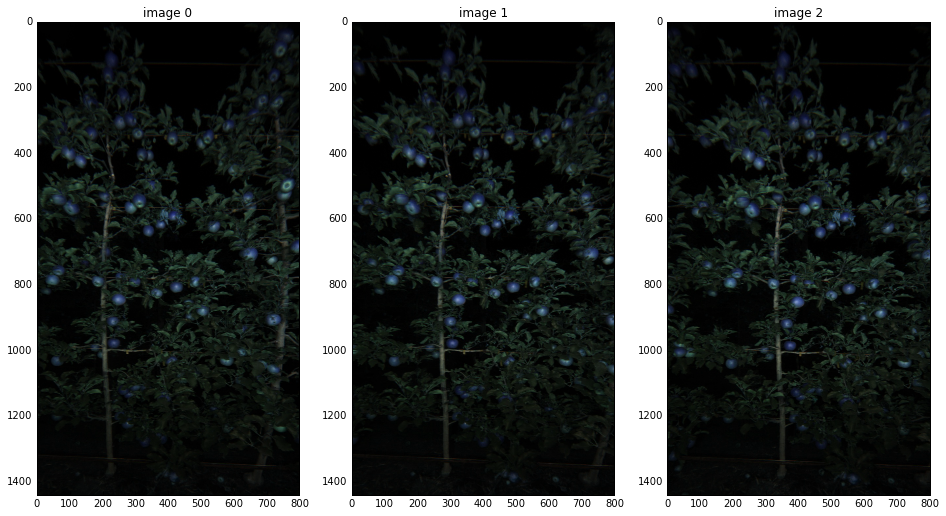

In [35]:
# Load n images
n = 3
images = []
for i in range(n):
    im = reader.read_image(i)
    im = rotate_image(im)
    im = im[:1440, 200:1000, :]
    images.append(im)

def plot_images(images):
    fig = plt.figure(figsize=(16, 9))
    for i, image in enumerate(images):
        ax = fig.add_subplot(1, n, i + 1)
        ax.imshow(image)
        ax.set_title('image {0}'.format(i))

plot_images(images)

19
number of blobs in image0: 19


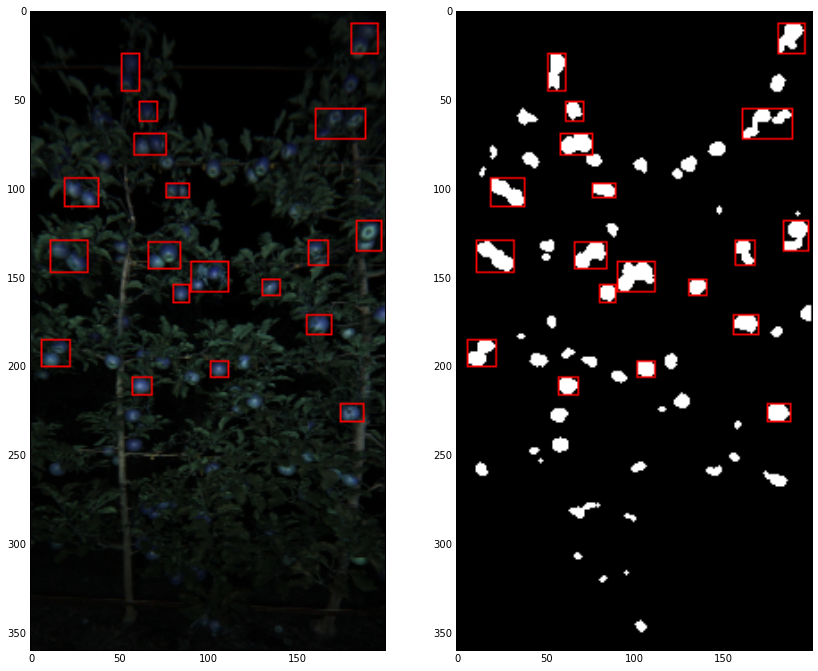

In [37]:
# We receive image0
image = images[0]

# Do detection
s, bw = detector.detect(image)
blobs, bw = region_props(bw)
blobs = thresh_blobs_area(blobs)

# We don't do optical flow because there's no previous image
prev_gray = None
gray = cv2.cvtColor(s.im_raw, cv2.COLOR_BGR2GRAY)

# initialize some new tracks and just be done
tracks = []
hsv = s.im_hsv

for blob in blobs:
    if is_blob_multiple(blob):
        bbox_region = extract_bbox(hsv[:, :, -1], blob['bbox'])
        num_peaks = num_local_maximas(bbox_region)
    else:
        num_peaks = 1

    track = FruitTrack(blob, num_peaks)
    tracks.append(track)

print(len(tracks))

# Save the current detections
prev_gray = gray
prev_blobs = blobs

# Visualization
disp_color = np.array(s.im_raw, copy=True)
disp_bw = cv2.cvtColor(bw, cv2.COLOR_GRAY2RGB)
draw_bboxes(disp_bw, blobs['bbox'], color=Colors.bbox_detection)
draw_bboxes(disp_color, blobs['bbox'], color=Colors.bbox_detection)

# Draw all detections
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(121)
plt.imshow(disp_color)
ax = fig.add_subplot(122)
plt.imshow(disp_bw, cmap=plt.cm.gray)
print('number of blobs in image0: {0}'.format(len(blobs)))

(19, 19)
valid: 16, invalid: 3
15
20
number of blobs in image0: 20


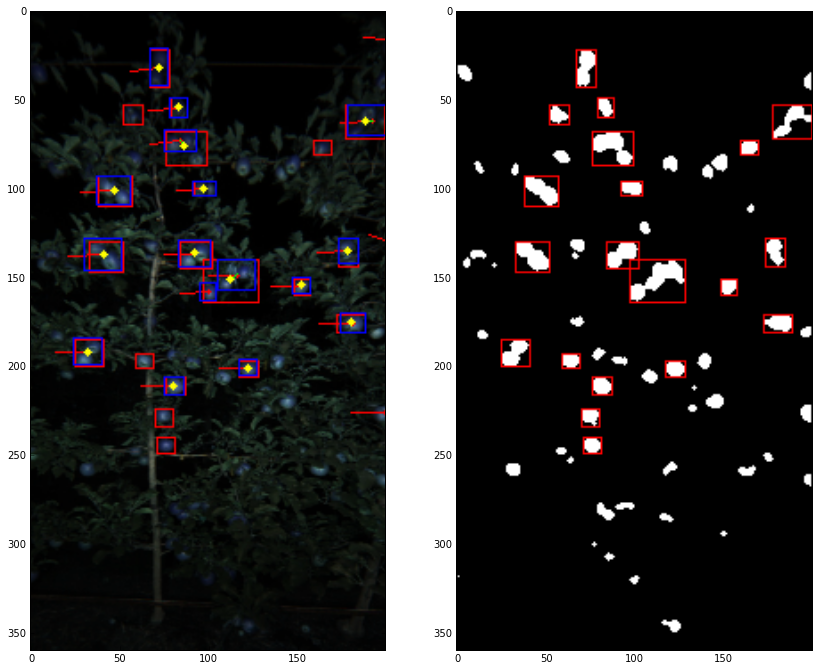

In [38]:
# We receive image1
image = images[1]

# Do detection
s, bw = detector.detect(image)
blobs, bw = region_props(bw)
blobs = thresh_blobs_area(blobs)

# Do optical flow stuff
gray = cv2.cvtColor(s.im_raw, cv2.COLOR_BGR2GRAY)
# This should be changed to bboxes that are tracked
prev_bboxes = prev_blobs['bbox']
p1s, p2s, sts = calc_bboxes_flow(prev_gray, gray, prev_bboxes)
flows = p2s - p1s

# Do some drawinngs
disp_color = np.array(s.im_raw, copy=True)
disp_bw = cv2.cvtColor(bw, cv2.COLOR_GRAY2RGB)
draw_optical_flow(disp_color, p1s, p2s, color=Colors.optical_flow)
draw_bboxes(disp_bw, blobs['bbox'], color=Colors.bbox_detection)
draw_bboxes(disp_color, blobs['bbox'], color=Colors.bbox_detection)

# Predict all valid tracks
print(len(tracks), len(prev_blobs))
valid_tracks = []
# All invalid tracks will be deleted at the end of each iterations
invalid_tracks = []
for track, flow, st in zip(tracks, flows, sts):
    # Only predict valid tracks
    if st == True:
        track.predict(flow)
        valid_tracks.append(track)
    else:
        invalid_tracks.append(track)

print('valid: {0}, invalid: {1}'.format(len(valid_tracks), len(invalid_tracks)))
bboxes_pred = []
tracks = valid_tracks
for track in tracks:
    bboxes_pred.append(track.bbox_pred)
bboxes_pred = np.array(bboxes_pred)
draw_bboxes(disp_color, bboxes_pred, color=Colors.bbox_prediction)

# Do the assignment
bboxes_detect = blobs['bbox']
assignment_cost = bboxes_assignment_cost(bboxes_pred, bboxes_detect)
matches, un_pred, un_detect = hungarian_assignment(assignment_cost)
draw_bboxes_matches(disp_color, matches, bboxes_pred, bboxes_detect, color=Colors.bbox_match)

# Correct all valid tracks and put invalid tracks into invalid_tracks
valid_tracks = []
for match in matches:
    i1, i2 = match
    track = tracks[i1]
    blob = blobs[i2]
    track.correct(blob)
    valid_tracks.append(track)

bboxes_correct = []
for track in valid_tracks:
    x, y = np.array(track.kf.x, dtype=int)
    cv2.circle(disp_color, (x, y), 2, color=(255, 255, 0), thickness=-1)
    
for i in un_pred:
    invalid_tracks.append(tracks[i])

print(len(valid_tracks))

# Spawn new tracks
for i in un_detect:
    blob = blobs[i]
    if is_blob_multiple(blob):
        bbox_region = extract_bbox(hsv, blob['bbox'])
        num_peaks = num_local_maximas(bbox_region)
    else:
        num_peaks = 1

    track = FruitTrack(blob, num_peaks)
    valid_tracks.append(track)
print(len(valid_tracks))

# Delete invalid tracks and add them to total counts
for track in invalid_tracks:
    # Check something and decide whether to add them to total counts
    pass

# Draw all detections
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(121)
plt.imshow(disp_color)
ax = fig.add_subplot(122)
plt.imshow(disp_bw, cmap=plt.cm.gray)
print('number of blobs in image0: {0}'.format(len(blobs)))